In [1]:
# ═══════════════════════════════════════════════════════════════════════════
# 1. SETUP & IMPORTS
# ═══════════════════════════════════════════════════════════════════════════

import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import deque, defaultdict, Counter
from typing import Tuple, List, Dict

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Matplotlib styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")
print("✓ Environment ready for training\n")


✓ All imports successful!
✓ Environment ready for training



In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# 2. HVAC ENVIRONMENT
# ═══════════════════════════════════════════════════════════════════════════

class HVACEnvironment:
    """
    HVAC Environment Simulation
    - Temperature control (15-30°C)
    - Humidity management (20-70%)
    - Power optimization
    - Dynamic occupancy (Low/Medium/High)
    """

    def __init__(self, initial_temp: float = 25.0, initial_humidity: float = 50.0):
        # Environment parameters
        self.initial_temperature = initial_temp
        self.initial_humidity = initial_humidity
        self.setpoint_temperature = 22.0

        # State variables
        self.current_temperature = initial_temp
        self.current_humidity = initial_humidity
        self.current_watts = 0.0
        self.occupancy_level = 1  # 0: low, 1: medium, 2: high

        # HVAC modes
        self.ac_mode = "Balanced"
        self.heating_mode = "Balanced"
        self.ventilation_mode = "Balanced"

        # State bounds
        self.temp_min, self.temp_max = 15.0, 30.0
        self.humidity_min, self.humidity_max = 20.0, 70.0
        self.comfort_temp_min, self.comfort_temp_max = 20.0, 24.0

    def reset(self) -> List[float]:
        """Reset environment to initial state"""
        self.current_temperature = self.initial_temperature
        self.current_humidity = self.initial_humidity
        self.current_watts = 0.0
        self.occupancy_level = 1

        return [
            round(self.current_temperature, 2),
            round(self.current_humidity, 2),
            round(self.current_watts, 2),
            self.occupancy_level
        ]

    def _get_mode(self, action: int) -> str:
        """Map action index to mode string"""
        mode_map = {0: "Eco", 1: "Balanced", 2: "High Performance"}
        return mode_map.get(action, "Balanced")

    def _simulate_hvac_effects(self):
        """Simulate HVAC system effects on environment"""
        self.current_watts = 0.0

        # AC effects (cooling)
        ac_effects = {
            "Eco": (-0.5, 5.0),
            "Balanced": (-1.0, 10.0),
            "High Performance": (-1.5, 15.0)
        }
        temp_change, power = ac_effects[self.ac_mode]
        self.current_temperature += temp_change
        self.current_watts += power

        # Heating effects
        heating_effects = {
            "Eco": (0.5, 5.0),
            "Balanced": (1.0, 10.0),
            "High Performance": (1.5, 15.0)
        }
        temp_change, power = heating_effects[self.heating_mode]
        self.current_temperature += temp_change
        self.current_watts += power

        # Ventilation effects (affects humidity)
        ventilation_effects = {
            "Eco": (0.5, 5.0),
            "Balanced": (1.0, 10.0),
            "High Performance": (1.5, 15.0)
        }
        humidity_change, power = ventilation_effects[self.ventilation_mode]
        self.current_humidity += humidity_change
        self.current_watts += power

        # Occupancy effects
        if self.occupancy_level == 0:
            self.current_temperature += 0.1
            self.current_humidity -= 1.0
        elif self.occupancy_level == 2:
            self.current_temperature += 0.3
            self.current_humidity += 1.0

        # Clip to bounds
        self.current_temperature = np.clip(self.current_temperature, self.temp_min, self.temp_max)
        self.current_humidity = np.clip(self.current_humidity, self.humidity_min, self.humidity_max)

        # Random occupancy change (20% probability)
        if random.random() < 0.2:
            self.occupancy_level = random.choice([0, 1, 2])

    def step(self, ac_action: int, heating_action: int,
             ventilation_action: int) -> Tuple[List[float], float, bool]:
        """Take a step in the environment"""
        # Update modes
        self.ac_mode = self._get_mode(ac_action)
        self.heating_mode = self._get_mode(heating_action)
        self.ventilation_mode = self._get_mode(ventilation_action)

        # Simulate effects
        self._simulate_hvac_effects()

        # Calculate reward
        temp_penalty = abs(self.current_temperature - self.setpoint_temperature)
        power_penalty = self.current_watts / 100.0
        comfort_bonus = 1.0 if (20 <= self.current_temperature <= 24) else -2.0
        reward = -temp_penalty - power_penalty + comfort_bonus


        # Check if in comfort zone
        done = False # Let episodes run full length for learning


        # Return state
        next_state = [
            round(self.current_temperature, 2),
            round(self.current_humidity, 2),
            round(self.current_watts, 2),
            self.occupancy_level
        ]

        return next_state, round(reward, 4), done

print("✓ HVAC Environment created successfully!\n")

✓ HVAC Environment created successfully!



In [3]:
# ═══════════════════════════════════════════════════════════════════════════
# 3. RL AGENTS
# ═══════════════════════════════════════════════════════════════════════════

# ────────────────────────────────────────────────────────────────────────────
# 3.1 Q-LEARNING AGENT
# ────────────────────────────────────────────────────────────────────────────

class QLearningAgent:
    """Q-Learning: Off-policy TD Control"""

    def __init__(self, temp_bins=30, humidity_bins=50, watts_bins=11,
                 learning_rate=0.05, discount_factor=0.99, epsilon=1.0,
                 epsilon_decay=0.9995, epsilon_min=0.01):

        self.temp_bins = temp_bins
        self.humidity_bins = humidity_bins
        self.watts_bins = watts_bins
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Initialize Q-table: [temp][humidity][watts][occupancy][action]
        self.q_table = np.zeros((temp_bins, humidity_bins, watts_bins, 3, 27))

        # Create action space: all combinations of (ac, heating, ventilation)
        self.action_space = [(ac, h, v) for ac in range(3)
                            for h in range(3) for v in range(3)]

    def discretize_state(self, state: List[float]) -> Tuple[int, int, int, int]:
        """Convert continuous state to discrete indices"""
        temp, humidity, watts, occupancy = state

        temp_idx = int((temp - 15.0) / 15.0 * self.temp_bins)
        temp_idx = np.clip(temp_idx, 0, self.temp_bins - 1)

        humidity_idx = int((humidity - 20.0) / 50.0 * self.humidity_bins)
        humidity_idx = np.clip(humidity_idx, 0, self.humidity_bins - 1)

        watts_idx = min(int(watts / 5), self.watts_bins - 1)

        return (temp_idx, humidity_idx, watts_idx, int(occupancy))

    def choose_action(self, state: List[float]) -> Tuple[int, int, int]:
        """Epsilon-greedy action selection"""
        state_idx = self.discretize_state(state)

        if np.random.random() < self.epsilon:
            action_idx = np.random.randint(0, 27)
        else:
            action_idx = np.argmax(self.q_table[state_idx])

        return self.action_space[action_idx]

    def update_q_table(self, state, action, reward, next_state, done):
        """Q-learning update rule"""
        state_idx = self.discretize_state(state)
        next_state_idx = self.discretize_state(next_state)
        action_idx = self.action_space.index(action)

        current_q = self.q_table[state_idx][action_idx]

        if done:
            target_q = reward
        else:
            max_next_q = np.max(self.q_table[next_state_idx])
            target_q = reward + self.gamma * max_next_q

        self.q_table[state_idx][action_idx] = current_q + self.alpha * (target_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ────────────────────────────────────────────────────────────────────────────
# 3.2 SARSA AGENT
# ────────────────────────────────────────────────────────────────────────────

class SARSAAgent:
    """SARSA: On-policy TD Control"""

    def __init__(self, temp_bins=30, humidity_bins=50, watts_bins=11,
                 learning_rate=0.1, discount_factor=0.95, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01):

        self.temp_bins = temp_bins
        self.humidity_bins = humidity_bins
        self.watts_bins = watts_bins
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = np.zeros((temp_bins, humidity_bins, watts_bins, 3, 27))
        self.action_space = [(ac, h, v) for ac in range(3)
                            for h in range(3) for v in range(3)]

    def discretize_state(self, state):
        temp, humidity, watts, occupancy = state
        temp_idx = int((temp - 15.0) / 15.0 * self.temp_bins)
        temp_idx = np.clip(temp_idx, 0, self.temp_bins - 1)
        humidity_idx = int((humidity - 20.0) / 50.0 * self.humidity_bins)
        humidity_idx = np.clip(humidity_idx, 0, self.humidity_bins - 1)
        watts_idx = min(int(watts / 5), self.watts_bins - 1)
        return (temp_idx, humidity_idx, watts_idx, int(occupancy))

    def choose_action(self, state):
        state_idx = self.discretize_state(state)
        if np.random.random() < self.epsilon:
            action_idx = np.random.randint(0, 27)
        else:
            action_idx = np.argmax(self.q_table[state_idx])
        return self.action_space[action_idx]

    def update_q_table(self, state, action, reward, next_state, next_action, done):
        """SARSA update (uses next action, not max)"""
        state_idx = self.discretize_state(state)
        next_state_idx = self.discretize_state(next_state)
        action_idx = self.action_space.index(action)
        next_action_idx = self.action_space.index(next_action)

        current_q = self.q_table[state_idx][action_idx]

        if done:
            target_q = reward
        else:
            next_q = self.q_table[next_state_idx][next_action_idx]
            target_q = reward + self.gamma * next_q

        self.q_table[state_idx][action_idx] = current_q + self.alpha * (target_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ────────────────────────────────────────────────────────────────────────────
# 3.3 MONTE CARLO AGENT
# ────────────────────────────────────────────────────────────────────────────

class MonteCarloAgent:
    """Monte Carlo Control: Episode-based learning"""

    def __init__(self, temp_bins=30, humidity_bins=50, watts_bins=11,
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):

        self.temp_bins = temp_bins
        self.humidity_bins = humidity_bins
        self.watts_bins = watts_bins
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = np.zeros((temp_bins, humidity_bins, watts_bins, 3, 27))
        self.returns = defaultdict(list)
        self.action_space = [(ac, h, v) for ac in range(3)
                            for h in range(3) for v in range(3)]

    def discretize_state(self, state):
        temp, humidity, watts, occupancy = state
        temp_idx = int((temp - 15.0) / 15.0 * self.temp_bins)
        temp_idx = np.clip(temp_idx, 0, self.temp_bins - 1)
        humidity_idx = int((humidity - 20.0) / 50.0 * self.humidity_bins)
        humidity_idx = np.clip(humidity_idx, 0, self.humidity_bins - 1)
        watts_idx = min(int(watts / 5), self.watts_bins - 1)
        return (temp_idx, humidity_idx, watts_idx, int(occupancy))

    def choose_action(self, state):
        state_idx = self.discretize_state(state)
        if np.random.random() < self.epsilon:
            action_idx = np.random.randint(0, 27)
        else:
            action_idx = np.argmax(self.q_table[state_idx])
        return self.action_space[action_idx]

    def update_from_episode(self, episode):
        """Update Q-values from complete episode"""
        states_actions = [(s, a) for s, a, r in episode]

        G = 0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            state_idx = self.discretize_state(state)
            action_idx = self.action_space.index(action)

            # First-visit MC
            if (state, action) not in states_actions[:t]:
                key = (state_idx, action_idx)
                self.returns[key].append(G)
                self.q_table[state_idx][action_idx] = np.mean(self.returns[key])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ────────────────────────────────────────────────────────────────────────────
# 3.4 DEEP Q-NETWORK (DQN) AGENT
# ────────────────────────────────────────────────────────────────────────────

class SimpleNN:
    """Simple Neural Network for DQN"""

    def __init__(self, input_size, hidden_sizes, output_size):
        self.layers = []
        sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(sizes) - 1):
            self.layers.append({
                'weights': np.random.randn(sizes[i], sizes[i+1]) * 0.1,
                'biases': np.zeros((1, sizes[i+1]))
            })

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, x):
        self.activations = [x]
        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['weights']) + layer['biases']
            a = self.relu(z) if i < len(self.layers) - 1 else z
            self.activations.append(a)
        return self.activations[-1]

    def backward(self, x, y_true, lr=0.001):
        m = x.shape[0]
        delta = self.activations[-1] - y_true

        for i in range(len(self.layers) - 1, -1, -1):
            grad_w = np.dot(self.activations[i].T, delta) / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m

            self.layers[i]['weights'] -= lr * grad_w
            self.layers[i]['biases'] -= lr * grad_b

            if i > 0:
                delta = np.dot(delta, self.layers[i]['weights'].T)
                delta *= (self.activations[i] > 0).astype(float)

    def copy_weights_from(self, other):
        for i in range(len(self.layers)):
            self.layers[i]['weights'] = other.layers[i]['weights'].copy()
            self.layers[i]['biases'] = other.layers[i]['biases'].copy()

class DQNAgent:
    """Deep Q-Network with Experience Replay"""

    def __init__(self, learning_rate=0.001, discount_factor=0.95, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, batch_size=32):

        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.q_network = SimpleNN(4, [64, 64], 27)
        self.target_network = SimpleNN(4, [64, 64], 27)
        self.target_network.copy_weights_from(self.q_network)

        self.memory = deque(maxlen=2000)
        self.action_space = [(ac, h, v) for ac in range(3)
                            for h in range(3) for v in range(3)]
        self.update_counter = 0

    def preprocess_state(self, state):
        temp, humidity, watts, occupancy = state
        temp_norm = (temp - 15.0) / 15.0
        humidity_norm = (humidity - 20.0) / 50.0
        watts_norm = watts / 50.0
        occupancy_norm = occupancy / 2.0
        return np.array([[temp_norm, humidity_norm, watts_norm, occupancy_norm]])

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action_idx = np.random.randint(0, 27)
        else:
            state_processed = self.preprocess_state(state)
            q_values = self.q_network.forward(state_processed)
            action_idx = np.argmax(q_values[0])
        return self.action_space[action_idx]

    def remember(self, state, action, reward, next_state, done):
        action_idx = self.action_space.index(action)
        self.memory.append((state, action_idx, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states = np.vstack([self.preprocess_state(s) for s, _, _, _, _ in batch])
        next_states = np.vstack([self.preprocess_state(ns) for _, _, _, ns, _ in batch])

        current_q = self.q_network.forward(states)
        next_q = self.target_network.forward(next_states)
        target_q = current_q.copy()

        for i, (_, action_idx, reward, _, done) in enumerate(batch):
            if done:
                target_q[i, action_idx] = reward
            else:
                target_q[i, action_idx] = reward + self.gamma * np.max(next_q[i])

        self.q_network.backward(states, target_q, self.learning_rate)

        self.update_counter += 1
        if self.update_counter % 10 == 0:
            self.target_network.copy_weights_from(self.q_network)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✓ All RL Agents created successfully!\n")

✓ All RL Agents created successfully!



In [4]:
# ═══════════════════════════════════════════════════════════════════════════
# 4. TRAINING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def train_agent(env, agent, agent_type, num_episodes=1000, max_steps=100, verbose=False):
    """Universal training function for all agents"""

    episode_rewards = []
    avg_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        # For SARSA and Monte Carlo
        if agent_type == "SARSA":
            action = agent.choose_action(state)
        episode_data = []  # For Monte Carlo

        for step in range(max_steps):
            if agent_type == "SARSA":
                next_state, reward, done = env.step(*action)
                next_action = agent.choose_action(next_state)
                agent.update_q_table(state, action, reward, next_state, next_action, done)
                action = next_action
            elif agent_type == "Monte Carlo":
                action = agent.choose_action(state)
                next_state, reward, done = env.step(*action)
                episode_data.append((state, action, reward))
            elif agent_type == "DQN":
                action = agent.choose_action(state)
                next_state, reward, done = env.step(*action)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
            else:  # Q-Learning
                action = agent.choose_action(state)
                next_state, reward, done = env.step(*action)
                agent.update_q_table(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

            if done:
                break

        # Monte Carlo episode update
        if agent_type == "Monte Carlo":
            agent.update_from_episode(episode_data)

        agent.decay_epsilon()
        episode_rewards.append(total_reward)

        window = min(100, episode + 1)
        avg_reward = np.mean(episode_rewards[-window:])
        avg_rewards.append(avg_reward)

        if verbose and (episode + 1) % 100 == 0:
            print(f"  Episode {episode + 1}/{num_episodes} | Avg Reward: {avg_reward:.4f} | ε: {agent.epsilon:.4f}")

    return episode_rewards, avg_rewards

print("✓ Training functions ready!\n")

✓ Training functions ready!



In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# 5. COMPARISON & EVALUATION
# ═══════════════════════════════════════════════════════════════════════════

def evaluate_agent(env, agent, agent_type, num_episodes=100):
    """Evaluate trained agent performance"""

    total_rewards = []
    temperatures = []
    power_consumptions = []
    comfort_violations = 0
    episode_lengths = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0  # Pure exploitation

    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_len = 0

        for step in range(100): # Still evaluate for max 100 steps
            action = agent.choose_action(state)
            next_state, reward, done = env.step(*action)

            episode_reward += reward
            temperatures.append(next_state[0])
            power_consumptions.append(next_state[2])

            state = next_state
            episode_len += 1

            if done:
                comfort_violations += 1
                break
        episode_lengths.append(episode_len)

        total_rewards.append(episode_reward)

    agent.epsilon = old_epsilon

    return {
        'mean_reward': np.mean(total_rewards),
        'std_reward': np.std(total_rewards),
        'mean_temp': np.mean(temperatures),
        'temp_std': np.std(temperatures),
        'mean_power': np.mean(power_consumptions),
        'power_std': np.std(power_consumptions),
        'comfort_violations': comfort_violations,
        'mean_episode_length': np.mean(episode_lengths),
        'std_episode_length': np.std(episode_lengths)
    }

def compare_all_algorithms(num_episodes=1000, verbose=True):
    """Train and compare all algorithms"""

    print("="*80)
    print("TRAINING ALL RL ALGORITHMS".center(80))
    print("="*80)

    algorithms = {
        'Q-Learning': ('Q-Learning', QLearningAgent),
        'SARSA': ('SARSA', SARSAAgent),
        'Monte Carlo': ('Monte Carlo', MonteCarloAgent),
        'DQN': ('DQN', DQNAgent)
    }

    results = {}

    for alg_name, (agent_type, agent_class) in algorithms.items():
        print(f"\n{'─'*80}")
        print(f"Training {alg_name}...".center(80))
        print(f"{'─'*80}")

        env = HVACEnvironment()
        agent = agent_class()

        # Apply specific hyperparameter tuning for Q-Learning
        if alg_name == 'Q-Learning':
             agent = agent_class(learning_rate=0.05, discount_factor=0.99, epsilon_decay=0.9995)


        start_time = time.time()
        rewards, avg_rewards = train_agent(env, agent, agent_type,
                                          num_episodes=num_episodes, verbose=verbose)
        training_time = time.time() - start_time

        print(f"\n  ✓ Training complete in {training_time:.2f}s")
        print(f"  ✓ Final avg reward: {avg_rewards[-1]:.4f}")

        # Evaluate
        eval_metrics = evaluate_agent(env, agent, agent_type)

        results[alg_name] = {
            'rewards': rewards,
            'avg_rewards': avg_rewards,
            'training_time': training_time,
            'eval_metrics': eval_metrics,
            'agent': agent,
            'env': env
        }

    return results

print("✓ Comparison framework ready!\n")

✓ Comparison framework ready!



In [6]:
# ═══════════════════════════════════════════════════════════════════════════
# 6. VISUALIZATION & DEMO
# ═══════════════════════════════════════════════════════════════════════════

def plot_comparison_results(results):
    """Create comprehensive comparison visualizations"""

    fig = plt.figure(figsize=(18, 14)) # Increased figure height

    # 1. Training Curves
    ax1 = plt.subplot(3, 3, 1) # Adjusted grid layout
    for alg_name, data in results.items():
        ax1.plot(data['avg_rewards'], label=alg_name, linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward')
    ax1.set_title('Training Progress', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Final Performance
    ax2 = plt.subplot(3, 3, 2) # Adjusted grid layout
    alg_names = list(results.keys())
    mean_rewards = [results[alg]['eval_metrics']['mean_reward'] for alg in alg_names]
    std_rewards = [results[alg]['eval_metrics']['std_reward'] for alg in alg_names]

    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    bars = ax2.bar(alg_names, mean_rewards, yerr=std_rewards, capsize=5, color=colors, alpha=0.7)
    ax2.set_ylabel('Mean Reward')
    ax2.set_title('Final Performance Comparison', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

    # 3. Power Consumption
    ax3 = plt.subplot(3, 3, 3) # Adjusted grid layout
    power_means = [results[alg]['eval_metrics']['mean_power'] for alg in alg_names]
    power_stds = [results[alg]['eval_metrics']['power_std'] for alg in alg_names]
    bars = ax3.bar(alg_names, power_means, yerr=power_stds, capsize=5, color=colors, alpha=0.7)
    ax3.set_ylabel('Power Consumption (W)')
    ax3.set_title('Energy Efficiency', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=15, ha='right')

    # 4. Temperature Control
    ax4 = plt.subplot(3, 3, 4) # Adjusted grid layout
    temp_means = [results[alg]['eval_metrics']['mean_temp'] for alg in alg_names]
    temp_stds = [results[alg]['eval_metrics']['temp_std'] for alg in alg_names]
    bars = ax4.bar(alg_names, temp_means, yerr=temp_stds, capsize=5, color=colors, alpha=0.7)
    ax4.axhline(y=22.0, color='red', linestyle='--', linewidth=2, label='Target (22°C)')
    ax4.axhspan(20, 24, alpha=0.2, color='green', label='Comfort Zone')
    ax4.set_ylabel('Temperature (°C)')
    ax4.set_title('Temperature Control Accuracy', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3, axis='y')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=15, ha='right')

    # 5. Comfort Violations
    ax5 = plt.subplot(3, 3, 5) # Adjusted grid layout
    violations = [results[alg]['eval_metrics']['comfort_violations'] for alg in alg_names]
    bars = ax5.bar(alg_names, violations, color=colors, alpha=0.7)
    ax5.set_ylabel('Number of Violations')
    ax5.set_title('Comfort Zone Violations (out of 100)', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=15, ha='right')

    # 6. Training Time
    ax6 = plt.subplot(3, 3, 6) # Adjusted grid layout
    training_times = [results[alg]['training_time'] for alg in alg_names]
    bars = ax6.bar(alg_names, training_times, color=colors, alpha=0.7)
    ax6.set_ylabel('Time (seconds)')
    ax6.set_title('Training Time Comparison', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=15, ha='right')

    # 7. Episode Length
    ax7 = plt.subplot(3, 3, 7) # Added new subplot
    episode_lengths = [results[alg]['eval_metrics']['mean_episode_length'] for alg in alg_names]
    bars = ax7.bar(alg_names, episode_lengths, color=colors, alpha=0.7)
    ax7.set_ylabel('Average Episode Length')
    ax7.set_title('Average Episode Length (Eval)', fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=15, ha='right')


    plt.tight_layout()
    plt.savefig('hvac_comparison_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Comparison plot saved as 'hvac_comparison_results.png'")
    plt.show()

def print_summary_table(results):
    """Print formatted comparison table"""

    print("\n" + "="*120) # Increased width
    print(" FINAL COMPARISON SUMMARY ".center(120, "=")) # Increased width
    print("="*120) # Increased width
    print(f"{'Algorithm':<15} {'Reward':<20} {'Temp (°C)':<20} {'Power (W)':<20} {'Violations':<15} {'Avg Epi Length':<18}") # Added Avg Epi Length
    print("-"*120) # Increased width

    for alg_name, data in results.items():
        m = data['eval_metrics']
        print(f"{alg_name:<15} "
              f"{m['mean_reward']:>7.4f} ± {m['std_reward']:<6.4f}   "
              f"{m['mean_temp']:>6.2f} ± {m['temp_std']:<6.2f}   "
              f"{m['mean_power']:>6.2f} ± {m['power_std']:<6.2f}   "
              f"{m['comfort_violations']:>10}/100   "
              f"{m['mean_episode_length']:>10.2f} ± {m['std_episode_length']:<6.2f}") # Added Avg Epi Length

    print("="*120) # Increased width

    # Find best performer
    best_alg = max(results.keys(), key=lambda x: results[x]['eval_metrics']['mean_reward'])
    print(f"\n🏆 Best Algorithm: {best_alg}")
    print(f"   Reward: {results[best_alg]['eval_metrics']['mean_reward']:.4f}")
    print(f"   Temperature: {results[best_alg]['eval_metrics']['mean_temp']:.2f}°C")
    print(f"   Power: {results[best_alg]['eval_metrics']['mean_power']:.2f}W")
    print(f"   Average Episode Length: {results[best_alg]['eval_metrics']['mean_episode_length']:.2f}") # Added Avg Epi Length
    print("="*120 + "\n") # Increased width

def demo_trained_agent(agent, env, agent_name="Agent", num_steps=50):
    """Demonstrate trained agent with detailed visualization"""

    print("\n" + "="*80)
    print(f" DEMONSTRATING {agent_name.upper()} ".center(80, "="))
    print("="*80)

    state = env.reset()

    # Storage
    temperatures = [state[0]]
    humidities = [state[1]]
    power_consumptions = [state[2]]
    rewards = []
    ac_modes = []
    heating_modes = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0

    print(f"\nInitial State: Temp={state[0]:.2f}°C, Humidity={state[1]:.2f}%, Power={state[2]:.2f}W\n")
    print(f"{'Step':<6} {'Action':<35} {'Temp':<10} {'Power':<10} {'Reward':<12}")
    print("-"*80)

    total_reward = 0

    for step in range(num_steps):
        action = agent.choose_action(state)
        next_state, reward, done = env.step(*action)

        temperatures.append(next_state[0])
        humidities.append(next_state[1])
        power_consumptions.append(next_state[2])
        rewards.append(reward)
        ac_modes.append(env.ac_mode)
        heating_modes.append(env.heating_mode)

        total_reward += reward

        if step % 5 == 0 or done:
            action_str = f"AC:{env.ac_mode[:3]}, H:{env.heating_mode[:3]}, V:{env.ventilation_mode[:3]}"
            status = "✓" if not done else "✗"
            print(f"{step:<6} {action_str:<35} {next_state[0]:<10.2f} {next_state[2]:<10.2f} {reward:<12.4f} {status}")

        state = next_state
        if done:
            print(f"\n⚠ Episode ended at step {step+1} - Temperature out of comfort zone!")
            break

    agent.epsilon = old_epsilon

    print(f"\n{'─'*80}")
    print(f"Total Reward: {total_reward:.4f} | Average: {total_reward/len(rewards):.4f}")
    print(f"Final Temp: {temperatures[-1]:.2f}°C | Avg Power: {np.mean(power_consumptions):.2f}W")
    print("="*80 + "\n")

    # Visualize
    plot_demo_performance(temperatures, humidities, power_consumptions, rewards,
                         ac_modes, heating_modes, agent_name)

    return {
        'temperatures': temperatures,
        'rewards': rewards,
        'total_reward': total_reward,
        'episode_length': len(rewards)
    }

def plot_demo_performance(temps, humidity, power, rewards, ac_modes, heating_modes, agent_name):
    """Plot detailed agent performance"""

    fig = plt.figure(figsize=(16, 8))
    steps = range(len(temps))

    # 1. Temperature Control
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(steps, temps, 'b-', linewidth=2.5, label='Temperature')
    ax1.axhline(y=22.0, color='red', linestyle='--', linewidth=2, label='Target')
    ax1.fill_between(steps, 20.0, 24.0, alpha=0.2, color='green', label='Comfort Zone')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title(f'{agent_name} - Temperature Control', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Humidity
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(steps, humidity, 'g-', linewidth=2.5)
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Humidity (%)')
    ax2.set_title('Humidity Management', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # 3. Power Consumption
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(steps[1:], power[1:], 'r-', linewidth=2.5)
    ax3.fill_between(steps[1:], 0, power[1:], alpha=0.3, color='red')
    avg_power = np.mean(power[1:])
    ax3.axhline(y=avg_power, color='darkred', linestyle='--',
                label=f'Avg: {avg_power:.1f}W', linewidth=2)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Power (W)')
    ax3.set_title('Power Consumption', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Rewards
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(rewards, 'purple', linewidth=2.5)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    cumulative = np.cumsum(rewards)
    ax4_twin = ax4.twinx()
    ax4_twin.plot(cumulative, 'orange', alpha=0.6, linestyle='--', linewidth=2)
    ax4_twin.set_ylabel('Cumulative Reward', color='orange')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Reward')
    ax4.set_title('Reward Over Time', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. HVAC Mode Distribution
    ax5 = plt.subplot(2, 3, 5)
    ac_counts = Counter(ac_modes)
    heating_counts = Counter(heating_modes)

    modes = ['Eco', 'Balanced', 'High Performance']
    ac_values = [ac_counts.get(mode, 0) for mode in modes]
    heating_values = [heating_counts.get(mode, 0) for mode in modes]

    x = np.arange(len(modes))
    width = 0.35

    ax5.bar(x - width/2, ac_values, width, label='AC', alpha=0.8, color='skyblue')
    ax5.bar(x + width/2, heating_values, width, label='Heating', alpha=0.8, color='salmon')
    ax5.set_xlabel('Mode')
    ax5.set_ylabel('Frequency')
    ax5.set_title('HVAC Mode Usage', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(modes, rotation=15, ha='right')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

    # 6. Performance Metrics Summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    metrics_text = f"""
    PERFORMANCE SUMMARY
    {'─'*35}

    Total Steps:           {len(rewards)}
    Total Reward:          {sum(rewards):.4f}
    Average Reward:        {np.mean(rewards):.4f}

    Final Temperature:     {temps[-1]:.2f}°C
    Avg Temperature:       {np.mean(temps):.2f}°C
    Temp Deviation:        {abs(np.mean(temps) - 22.0):.2f}°C

    Avg Power:             {np.mean(power):.2f}W
    Total Energy:          {sum(power):.2f}Wh

    Most Used AC Mode:     {ac_counts.most_common(1)[0][0] if ac_counts else 'N/A'}
    Most Used Heat Mode:   {heating_counts.most_common(1)[0][0] if heating_counts else 'N/A'}
    """

    ax6.text(0.1, 0.5, metrics_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='center', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'{agent_name.lower()}_demo.png', dpi=300, bbox_inches='tight')
    print(f"✓ Demo plot saved as '{agent_name.lower()}_demo.png'")
    plt.show()

def thermostat_baseline(state):
    """Simple thermostat logic"""
    temp = state[0]
    # AC, Heating, Ventilation
    if temp > 22.5:
        return (1, 0, 1)  # AC on, heating off, ventilation balanced
    elif temp < 21.5:
        return (0, 1, 1)  # AC off, heating on, ventilation balanced
    else:
        return (0, 0, 1)  # Maintain, ventilation balanced

def pid_controller(state):
    """PID control baseline (simplified)"""
    # This is a simplified example, a real PID would need state history and tuning
    error = 22.0 - state[0]
    # Map error magnitude to action intensity (0, 1, 2)
    ac_action = 0
    heating_action = 0
    if error > 0.5: # Too cold
        heating_action = min(2, int(error * 2)) # Scale error to 0-2 range
    elif error < -0.5: # Too hot
        ac_action = min(2, int(abs(error) * 2)) # Scale error to 0-2 range

    return (ac_action, heating_action, 1) # Keep ventilation balanced


def normalized_score(agent_reward, random_reward, optimal_reward):
    """Normalize to 0-100 scale"""
    # Avoid division by zero if optimal and random are the same
    if optimal_reward == random_reward:
        return 0 if agent_reward <= random_reward else 100
    return 100 * (agent_reward - random_reward) / (optimal_reward - random_reward)


def compare_with_baselines(trained_agent, env, agent_name="Trained Agent", num_episodes=20):
    """Compare trained agent with baseline strategies"""

    print("\n" + "="*80)
    print(f" BASELINE COMPARISON FOR {agent_name.upper()} ".center(80, "="))
    print("="*80 + "\n")

    strategies = {
        agent_name: lambda s: trained_agent.choose_action(s),
        'Random': lambda s: tuple(np.random.randint(0, 3, 3)),
        'Always Balanced': lambda s: (1, 1, 1),
        'Always Eco': lambda s: (0, 0, 0),
        'Always High Perf': lambda s: (2, 2, 2),
        'Thermostat': thermostat_baseline,
        'PID Controller': pid_controller
    }

    results = {}
    old_epsilon = trained_agent.epsilon
    trained_agent.epsilon = 0

    # Run baselines first to get range for normalization
    baseline_rewards = {}
    for strategy_name, strategy_func in strategies.items():
        if strategy_name == agent_name: # Skip the trained agent for this initial run
            continue

        total_rewards = []
        for _ in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            for step in range(100):
                action = strategy_func(state)
                next_state, reward, done = env.step(*action)
                episode_reward += reward
                state = next_state
                if done:
                    break # Baselines terminate on comfort violation
            # If episode terminated early, penalize remaining steps
            if done and step < 99:
                 remaining = 99 - step
                 episode_reward += remaining * (-10) # Penalty for early termination

            total_rewards.append(episode_reward)
        baseline_rewards[strategy_name] = np.mean(total_rewards)


    random_reward = baseline_rewards.get('Random', -1000) # Use a safe default if Random is missing
    # Estimate optimal reward - could be the best baseline or a theoretical max
    # For simplicity, let's assume the best non-random baseline is close to optimal
    non_random_baselines = [v for k, v in baseline_rewards.items() if k != 'Random']
    optimal_reward = max(non_random_baselines) if non_random_baselines else random_reward + 100 # Ensure optimal is higher

    print("Baseline Rewards (for Normalization):")
    for name, reward in baseline_rewards.items():
        print(f"  {name}: {reward:.4f}")
    print(f"  Estimated Optimal Reward: {optimal_reward:.4f}\n")


    # Now run the full comparison including the trained agent and normalization
    for strategy_name, strategy_func in strategies.items():
        total_rewards = []
        total_power = []
        violations = 0
        episode_lengths = []

        for _ in range(num_episodes):
            state = env.reset()
            episode_reward = 0
            episode_power = []
            episode_len = 0
            terminated_early = False

            for step in range(100): # Evaluate all strategies for max 100 steps
                action = strategy_func(state)
                next_state, reward, done = env.step(*action)

                episode_reward += reward
                episode_power.append(next_state[2])
                state = next_state
                episode_len += 1

                if done:
                    violations += 1
                    terminated_early = True
                    break # All strategies now terminate on comfort violation


            # Penalize if episode terminated early
            if terminated_early and episode_len < 100:
                 remaining = 100 - episode_len
                 episode_reward += remaining * (-10) # Penalty for early termination


            episode_lengths.append(episode_len)

            total_rewards.append(episode_reward)
            total_power.append(np.mean(episode_power) if episode_power else 0)

        mean_reward = np.mean(total_rewards)
        normalized_reward = normalized_score(mean_reward, random_reward, optimal_reward)

        results[strategy_name] = {
            'reward': mean_reward,
            'normalized_reward': normalized_reward,
            'power': np.mean(total_power),
            'violations': violations,
            'avg_episode_length': np.mean(episode_lengths)
        }

    trained_agent.epsilon = old_epsilon

    # Print table
    print(f"{'Strategy':<20} {'Avg Reward':<15} {'Normalized Reward':<20} {'Avg Power (W)':<15} {'Violations':<15} {'Avg Epi Length':<15}")
    print("-"*135)
    for strategy, metrics in results.items():
        marker = "🏆" if strategy == agent_name else "  "
        print(f"{marker} {strategy:<18} {metrics['reward']:<15.4f} {metrics['normalized_reward']:<20.2f} {metrics['power']:<15.2f} {metrics['violations']:<15} {metrics['avg_episode_length']:<15.2f}")
    print("="*135 + "\n")

    # Visualize - Update plots to include normalized reward
    fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Added space for normalized reward

    strategies_list = list(results.keys())
    rewards_list = [results[s]['reward'] for s in strategies_list]
    normalized_rewards_list = [results[s]['normalized_reward'] for s in strategies_list] # Normalized rewards list
    power_list = [results[s]['power'] for s in strategies_list]
    violations_list = [results[s]['violations'] for s in strategies_list]
    episode_length_list = [results[s]['avg_episode_length'] for s in strategies_list]

    colors = ['green'] + ['gray']*(len(strategies_list)-1)

    # Rewards
    axes[0].bar(strategies_list, rewards_list, color=colors, alpha=0.7)
    axes[0].set_ylabel('Average Reward')
    axes[0].set_title('Raw Reward Comparison', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Normalized Rewards
    axes[1].bar(strategies_list, normalized_rewards_list, color=colors, alpha=0.7)
    axes[1].set_ylabel('Normalized Score (0-100)')
    axes[1].set_title('Normalized Performance', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim(0, 100) # Normalize y-axis

    # Power
    axes[2].bar(strategies_list, power_list, color=colors, alpha=0.7)
    axes[2].set_ylabel('Average Power (W)')
    axes[2].set_title('Power Consumption', fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')

    # Violations
    axes[3].bar(strategies_list, violations_list, color=colors, alpha=0.7)
    axes[3].set_ylabel('Violations')
    axes[3].set_title(f'Comfort Violations (out of {num_episodes})', fontweight='bold')
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].grid(True, alpha=0.3, axis='y')

    # Episode Length
    axes[4].bar(strategies_list, episode_length_list, color=colors, alpha=0.7)
    axes[4].set_ylabel('Average Episode Length')
    axes[4].set_title('Average Episode Length', fontweight='bold')
    axes[4].tick_params(axis='x', rotation=45)
    axes[4].grid(True, alpha=0.3, axis='y')


    plt.tight_layout()
    plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Baseline comparison saved as 'baseline_comparison.png'\n")
    plt.show()

print("✓ Visualization functions ready!\n")

✓ Visualization functions ready!



============================== EXECUTION OPTIONS ===============================

Choose how to run the notebook:

1. FULL EXPERIMENT (Recommended):
   results = run_complete_experiment(num_episodes=15000) # Increased episodes

2. QUICK TEST (Faster, for testing):
   results = run_complete_experiment(quick_mode=True)

3. TRAIN SINGLE ALGORITHM:
   env = HVACEnvironment()
   agent = QLearningAgent(learning_rate=0.05, discount_factor=0.99, epsilon_decay=0.9995) # Using tuned parameters
   rewards, avg_rewards = train_agent(env, agent, "Q-Learning", num_episodes=10000, verbose=True)
   demo_trained_agent(agent, env, "Q-Learning", num_steps=100)

4. CUSTOM EXPERIMENT:
   # Mix and match any functions above



⏳ Uncomment the line below to start the experiment:


╔══════════════════════════════════════════════════════════════════════════════╗
║             ENERGY-EFFICIENT HVAC CONTROL - COMPLETE EXPERIMENT              ║
╚════════════════════════════════════════════════════════════════════

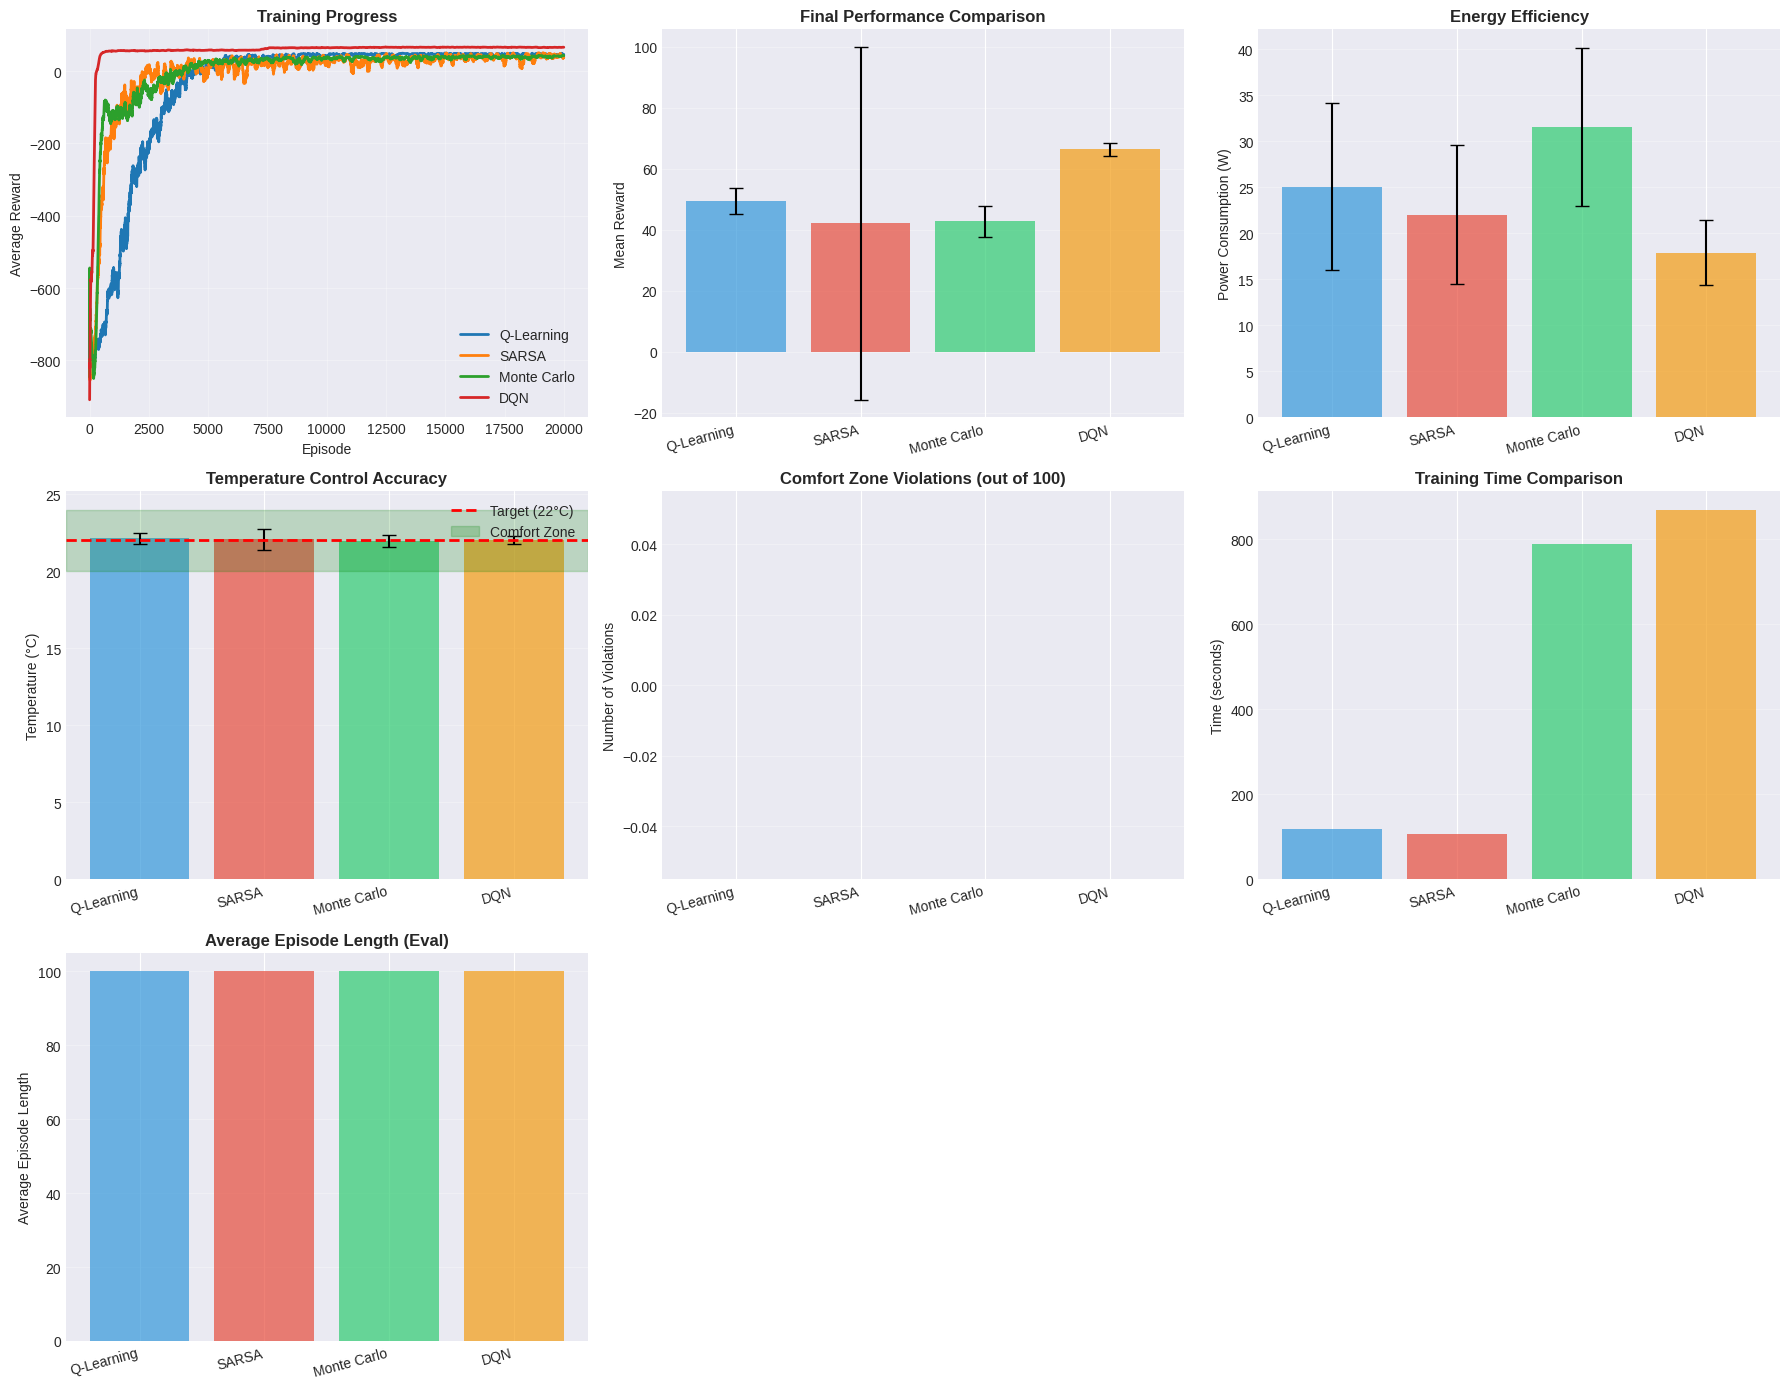


🎯 STEP 4: Demonstrating Best Agent (DQN)

============================== DEMONSTRATING DQN ===============================

Initial State: Temp=25.00°C, Humidity=50.00%, Power=0.00W

Step   Action                              Temp       Power      Reward      
--------------------------------------------------------------------------------
0      AC:Hig, H:Eco, V:Eco                24.00      25.00      -1.2500      ✓
5      AC:Eco, H:Eco, V:Eco                22.00      15.00      0.8500       ✓
10     AC:Bal, H:Eco, V:Bal                21.70      25.00      0.4500       ✓
15     AC:Bal, H:Eco, V:Bal                21.70      25.00      0.4500       ✓
20     AC:Bal, H:Eco, V:Bal                21.70      25.00      0.4500       ✓
25     AC:Bal, H:Eco, V:Eco                21.90      20.00      0.7000       ✓
30     AC:Eco, H:Eco, V:Eco                21.80      15.00      0.6500       ✓
35     AC:Eco, H:Eco, V:Eco                21.80      15.00      0.6500       ✓
40     AC:Eco, H:

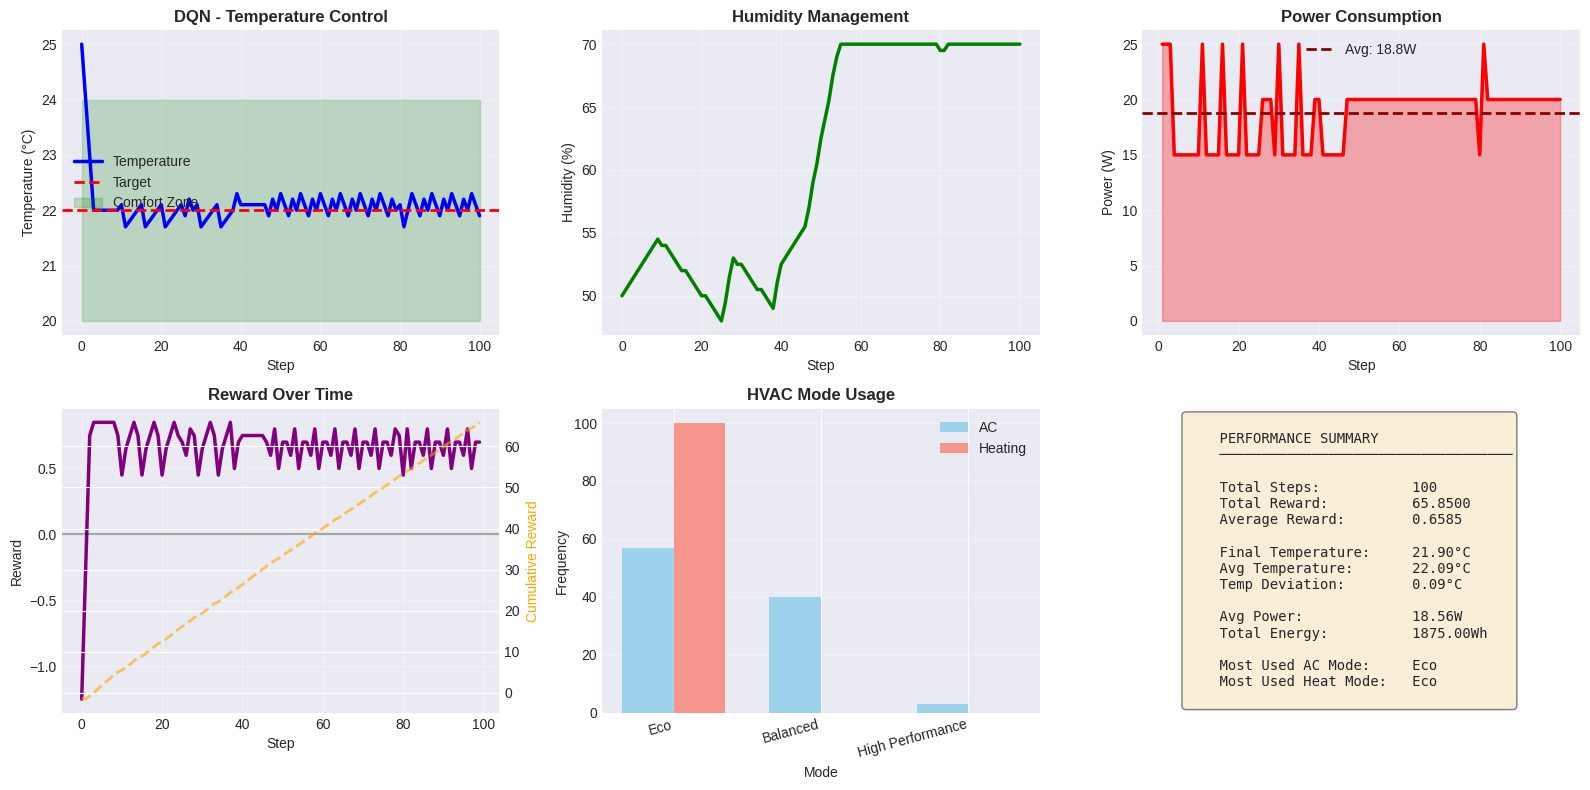

⚖️  STEP 5: Baseline Comparison

========================= BASELINE COMPARISON FOR DQN ==========================

Baseline Rewards (for Normalization):
  Random: -774.6995
  Always Balanced: -885.8580
  Always Eco: -884.2560
  Always High Perf: -917.6120
  Thermostat: 24.4075
  PID Controller: 35.9975
  Estimated Optimal Reward: 35.9975

Strategy             Avg Reward      Normalized Reward    Avg Power (W)   Violations      Avg Epi Length 
---------------------------------------------------------------------------------------------------------------------------------------
🏆 DQN                66.1540         103.72               17.92           0               100.00         
   Random             -754.1000       2.54                 29.88           0               100.00         
   Always Balanced    -890.1300       -14.24               30.00           0               100.00         
   Always Eco         -885.9160       -13.72               15.00           0               100.00

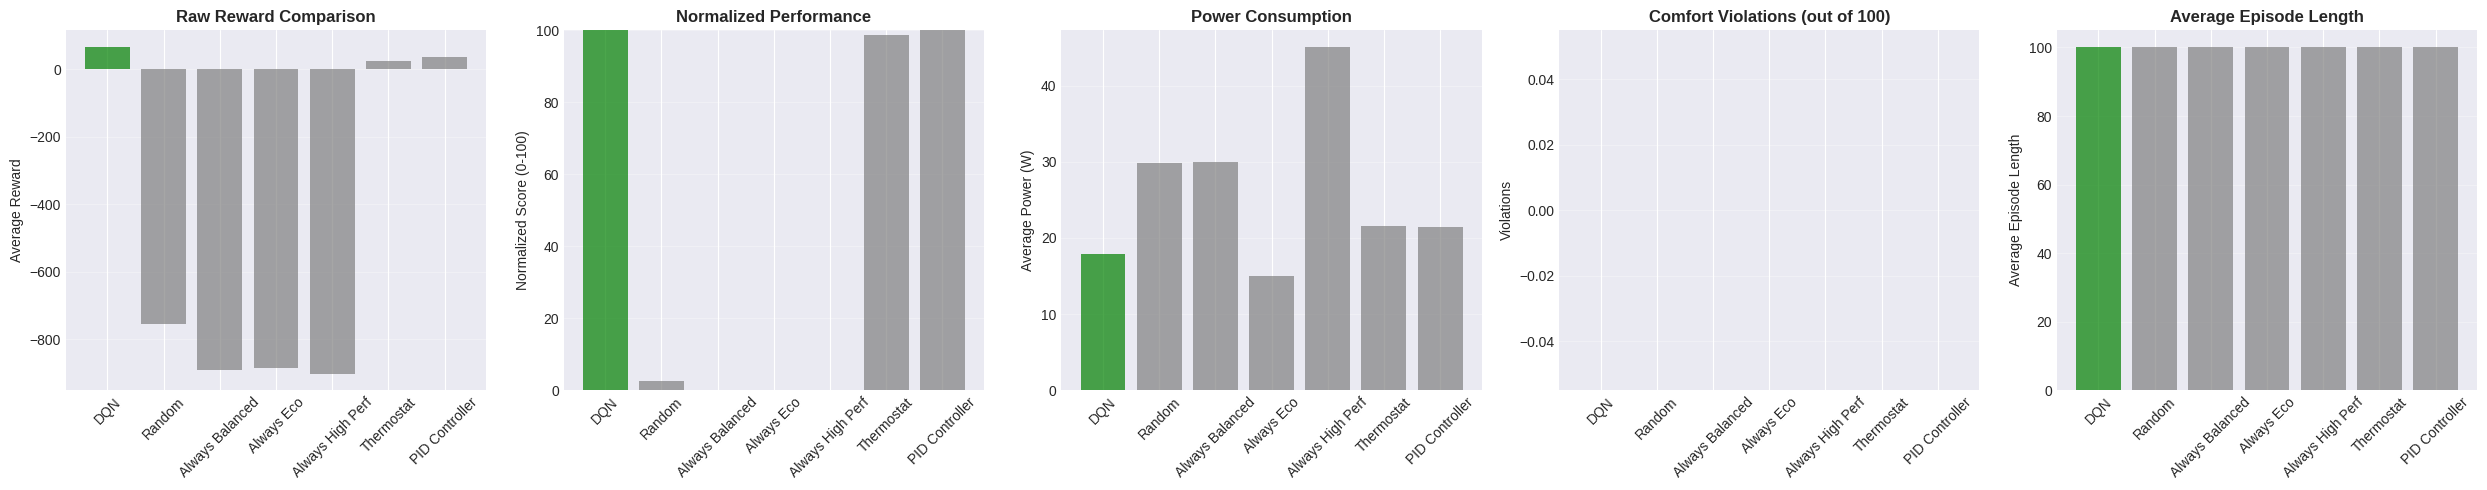


╔══════════════════════════════════════════════════════════════════════════════╗
║                           ✨ EXPERIMENT COMPLETE! ✨                           ║
╚══════════════════════════════════════════════════════════════════════════════╝

📁 Generated Files:
   - hvac_comparison_results.png
   - dqn_demo.png
   - baseline_comparison.png


✅ Notebook execution complete! Check the plots above.
💡 Tip: You can re-run with different parameters by calling the functions again.



In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# 7. MAIN EXECUTION - RUN THIS!
# ═══════════════════════════════════════════════════════════════════════════

def run_complete_experiment(num_episodes=15000, quick_mode=False): # Increased default episodes
    """
    Run the complete HVAC RL experiment

    Args:
        num_episodes: Number of training episodes (default: 15000)
        quick_mode: If True, runs faster with fewer episodes (default: False)
    """

    if quick_mode:
        num_episodes = 5000
        print(f"\n⚡ QUICK MODE: Using {num_episodes} episodes for faster execution\n")
    else:
        num_episodes = 20000 # Set full experiment episodes


    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " ENERGY-EFFICIENT HVAC CONTROL - COMPLETE EXPERIMENT ".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")

    # Step 1: Train and compare all algorithms
    print("📊 STEP 1: Training and Comparing All Algorithms")
    results = compare_all_algorithms(num_episodes=num_episodes, verbose=True)

    # Step 2: Print summary table
    print("\n📋 STEP 2: Performance Summary")
    print_summary_table(results)

    # Step 3: Visualize comparison
    print("📈 STEP 3: Generating Comparison Plots")
    plot_comparison_results(results)

    # Step 4: Demo best agent
    best_alg = max(results.keys(), key=lambda x: results[x]['eval_metrics']['mean_reward'])
    print(f"\n🎯 STEP 4: Demonstrating Best Agent ({best_alg})")
    best_agent = results[best_alg]['agent']
    best_env = results[best_alg]['env']
    demo_trained_agent(best_agent, best_env, best_alg, num_steps=100) # Increased demo steps

    # Step 5: Baseline comparison
    print(f"⚖️  STEP 5: Baseline Comparison")
    compare_with_baselines(best_agent, best_env, best_alg, num_episodes=100) # Increased baseline episodes for more reliable comparison

    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " ✨ EXPERIMENT COMPLETE! ✨ ".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")

    print("📁 Generated Files:")
    print("   - hvac_comparison_results.png")
    print(f"   - {best_alg.lower()}_demo.png")
    print("   - baseline_comparison.png\n")

    return results

# ═══════════════════════════════════════════════════════════════════════════
# EXECUTION OPTIONS
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print(" EXECUTION OPTIONS ".center(80, "="))
print("="*80)
print("""
Choose how to run the notebook:

1. FULL EXPERIMENT (Recommended):
   results = run_complete_experiment(num_episodes=15000) # Increased episodes

2. QUICK TEST (Faster, for testing):
   results = run_complete_experiment(quick_mode=True)

3. TRAIN SINGLE ALGORITHM:
   env = HVACEnvironment()
   agent = QLearningAgent(learning_rate=0.05, discount_factor=0.99, epsilon_decay=0.9995) # Using tuned parameters
   rewards, avg_rewards = train_agent(env, agent, "Q-Learning", num_episodes=10000, verbose=True)
   demo_trained_agent(agent, env, "Q-Learning", num_steps=100)

4. CUSTOM EXPERIMENT:
   # Mix and match any functions above

""")
print("="*80)
print("\n⏳ Uncomment the line below to start the experiment:\n")

# UNCOMMENT ONE OF THESE TO RUN:

# Run full experiment (takes ~15-30 minutes)
results = run_complete_experiment(num_episodes=20000)

# Run quick test (takes ~5-10 minutes)
#results = run_complete_experiment(quick_mode=True)

# Or train just one algorithm quickly:
# env = HVACEnvironment()
# agent = QLearningAgent(learning_rate=0.05, discount_factor=0.99, epsilon_decay=0.9995) # Using tuned parameters
# rewards, avg = train_agent(env, agent, "Q-Learning", num_episodes=5000, verbose=True) # Increased episodes
# demo_trained_agent(agent, env, "Q-Learning", num_steps=100) # Increased demo steps

print("\n✅ Notebook execution complete! Check the plots above.")
print("💡 Tip: You can re-run with different parameters by calling the functions again.\n")

                   ENHANCED DEMONSTRATION & REPORT GENERATION                   

This cell demonstrates DQN across multiple challenging scenarios
and generates comprehensive metrics for your project report.


╔══════════════════════════════════════════════════════════════════════════════╗
║                        COMPREHENSIVE SCENARIO TESTING                        ║
╚══════════════════════════════════════════════════════════════════════════════╝


1️⃣  HOT SUMMER DAY

Initial Conditions:
  Temperature: 28.0°C
  Humidity: 65.0%
  Target: 22°C (Comfort Zone: 20-24°C)

Step   Action                                   Temp     Humidity   Power    Reward    
------------------------------------------------------------------------------------------
0      AC:Hig, Heat:Eco, Vent:Bal               27.00    66.00      30.00    -7.3000    ✓
1      AC:Hig, Heat:Eco, Vent:Eco               26.00    66.50      25.00    -6.2500    ✓
2      AC:Hig, Heat:Eco, Vent:Eco               25.00    67.00   

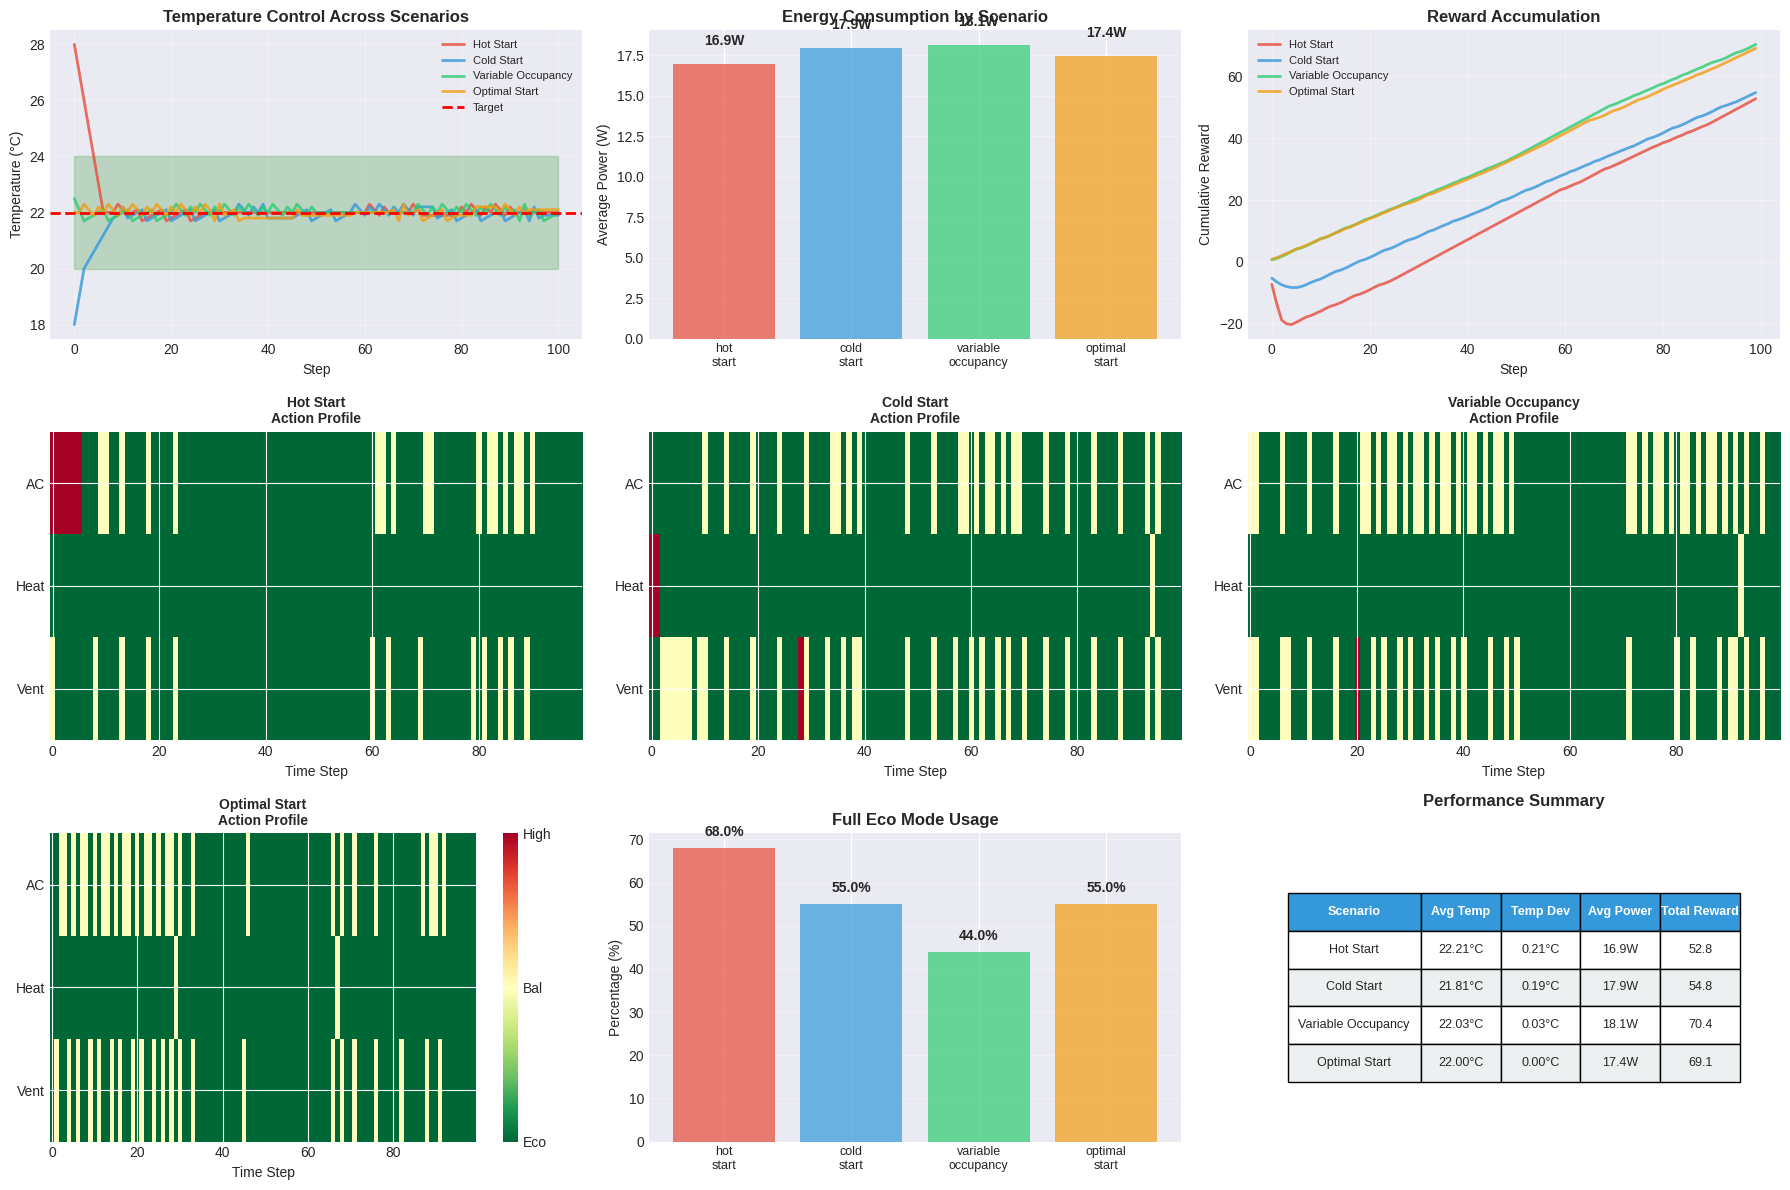


╔══════════════════════════════════════════════════════════════════════════════╗
║                         COMPREHENSIVE REPORT METRICS                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

                      1. ALGORITHM PERFORMANCE COMPARISON                       

Algorithm       Score        Rank     Temp Control    Energy Eff   Stability 
--------------------------------------------------------------------------------
DQN              66.31±2.15 1        Excellent       A+           High      
Q-Learning       49.42±4.22 2        Good            B            High      
Monte Carlo      42.70±5.11 3        Excellent       B            Medium    
SARSA            42.08±57.79 4        Excellent       A            Low       

                         2. SCENARIO-BASED PERFORMANCE                          

Scenario                       Reward       Temp Accuracy      Energy Used    
-------------------------------------------

In [9]:
"""
Enhanced Demonstration Scenarios & Report Generation
Demonstrates DQN performance across different challenging scenarios
"""

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ═══════════════════════════════════════════════════════════════════════════
# SCENARIO-BASED DEMONSTRATIONS
# ═══════════════════════════════════════════════════════════════════════════

def demonstrate_scenario(agent, scenario_name, initial_temp, initial_humidity,
                        occupancy_sequence=None, num_steps=100):
    """
    Demonstrate DQN performance in specific scenario

    Args:
        agent: Trained DQN agent
        scenario_name: Name of scenario
        initial_temp: Starting temperature
        initial_humidity: Starting humidity
        occupancy_sequence: Optional list of occupancy levels over time
        num_steps: Number of steps to run
    """
    # Create environment with scenario-specific initial conditions
    env = HVACEnvironment(initial_temp=initial_temp, initial_humidity=initial_humidity)
    state = env.reset()

    print(f"\nInitial Conditions:")
    print(f"  Temperature: {initial_temp}°C")
    print(f"  Humidity: {initial_humidity}%")
    print(f"  Target: 22°C (Comfort Zone: 20-24°C)\n")

    # Storage
    temperatures = [state[0]]
    humidities = [state[1]]
    power_consumptions = [state[2]]
    rewards = []
    ac_modes = []
    heating_modes = []
    ventilation_modes = []
    occupancy_levels = [state[3]]

    # Disable exploration
    old_epsilon = agent.epsilon
    agent.epsilon = 0

    print(f"{'Step':<6} {'Action':<40} {'Temp':<8} {'Humidity':<10} {'Power':<8} {'Reward':<10}")
    print("-"*90)

    total_reward = 0
    cooling_steps = 0
    heating_steps = 0
    eco_mode_steps = 0

    for step in range(num_steps):
        # Override occupancy if sequence provided
        if occupancy_sequence and step < len(occupancy_sequence):
            env.occupancy_level = occupancy_sequence[step]

        # Choose action
        action = agent.choose_action(state)

        # Take action
        next_state, reward, done = env.step(*action)

        # Store data
        temperatures.append(next_state[0])
        humidities.append(next_state[1])
        power_consumptions.append(next_state[2])
        occupancy_levels.append(next_state[3])
        rewards.append(reward)
        ac_modes.append(env.ac_mode)
        heating_modes.append(env.heating_mode)
        ventilation_modes.append(env.ventilation_mode)

        total_reward += reward

        # Count mode usage
        if env.heating_mode != "Eco":
            heating_steps += 1
        if env.ac_mode != "Eco":
            cooling_steps += 1
        if env.ac_mode == "Eco" and env.heating_mode == "Eco" and env.ventilation_mode == "Eco":
            eco_mode_steps += 1

        # Print key steps
        if step % 10 == 0 or step < 5 or done:
            action_str = f"AC:{env.ac_mode[:3]}, Heat:{env.heating_mode[:3]}, Vent:{env.ventilation_mode[:3]}"
            status = "✓" if not done else "✗"
            print(f"{step:<6} {action_str:<40} {next_state[0]:<8.2f} {next_state[1]:<10.2f} "
                  f"{next_state[2]:<8.2f} {reward:<10.4f} {status}")

        state = next_state

        if done:
            print(f"\nEpisode ended at step {step+1} - Temperature out of comfort zone!")
            break

    # Restore epsilon
    agent.epsilon = old_epsilon

    # Print summary
    print(f"\n{'─'*80}")
    print(f"SCENARIO SUMMARY:")
    print(f"  Total Steps: {len(rewards)}")
    print(f"  Total Reward: {total_reward:.4f}")
    print(f"  Average Reward: {total_reward/len(rewards):.4f}")
    print(f"  ")
    print(f"  Temperature Control:")
    print(f"    Initial: {initial_temp:.2f}°C → Final: {temperatures[-1]:.2f}°C")
    print(f"    Average: {np.mean(temperatures):.2f}°C (±{np.std(temperatures):.2f})")
    print(f"    Deviation from Target: {abs(np.mean(temperatures) - 22.0):.2f}°C")
    print(f"  ")
    print(f"  Energy Performance:")
    print(f"    Average Power: {np.mean(power_consumptions):.2f}W")
    print(f"    Total Energy: {sum(power_consumptions):.2f}Wh")
    print(f"  ")
    print(f"  Mode Usage:")
    print(f"    Heating Active: {heating_steps}/{len(rewards)} steps ({100*heating_steps/len(rewards):.1f}%)")
    print(f"    Cooling Active: {cooling_steps}/{len(rewards)} steps ({100*cooling_steps/len(rewards):.1f}%)")
    print(f"    Full Eco Mode: {eco_mode_steps}/{len(rewards)} steps ({100*eco_mode_steps/len(rewards):.1f}%)")
    print(f"{'='*80}\n")

    return {
        'temperatures': temperatures,
        'humidities': humidities,
        'power': power_consumptions,
        'rewards': rewards,
        'ac_modes': ac_modes,
        'heating_modes': heating_modes,
        'ventilation_modes': ventilation_modes,
        'total_reward': total_reward,
        'occupancy': occupancy_levels
    }


def run_all_scenarios(agent):
    """Run DQN through multiple challenging scenarios"""

    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " COMPREHENSIVE SCENARIO TESTING ".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")

    scenarios = {}

    # Scenario 1: Hot Start - Heavy Cooling Needed
    print("\n1️⃣  HOT SUMMER DAY")
    scenarios['hot_start'] = demonstrate_scenario(
        agent,
        "Hot Summer Day - Heavy Cooling Required",
        initial_temp=28.0,
        initial_humidity=65.0,
        num_steps=100
    )

    # Scenario 2: Cold Start - Heavy Heating Needed
    print("\n2️⃣  COLD WINTER MORNING")
    scenarios['cold_start'] = demonstrate_scenario(
        agent,
        "Cold Winter Morning - Heavy Heating Required",
        initial_temp=18.0,
        initial_humidity=35.0,
        num_steps=100
    )

    # Scenario 3: Variable Occupancy - Ventilation Challenge
    print("\n3️⃣  VARIABLE OCCUPANCY - OFFICE ENVIRONMENT")
    # Simulate office day: low → high → medium → high → low
    occupancy_pattern = [0]*20 + [2]*30 + [1]*20 + [2]*20 + [0]*10
    scenarios['variable_occupancy'] = demonstrate_scenario(
        agent,
        "Variable Occupancy - Ventilation Challenge",
        initial_temp=22.5,
        initial_humidity=50.0,
        occupancy_sequence=occupancy_pattern,
        num_steps=100
    )

    # Scenario 4: Near-Perfect Start
    print("\n4️⃣  OPTIMAL CONDITIONS - MAINTENANCE MODE")
    scenarios['optimal_start'] = demonstrate_scenario(
        agent,
        "Optimal Conditions - Energy Minimization",
        initial_temp=22.0,
        initial_humidity=50.0,
        num_steps=100
    )

    return scenarios


# ═══════════════════════════════════════════════════════════════════════════
# SCENARIO COMPARISON VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════

def plot_scenario_comparison(scenarios):
    """Create comprehensive comparison across scenarios"""

    fig = plt.figure(figsize=(18, 12))

    scenario_names = list(scenarios.keys())
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

    # 1. Temperature Trajectories
    ax1 = plt.subplot(3, 3, 1)
    for i, (name, data) in enumerate(scenarios.items()):
        ax1.plot(data['temperatures'], label=name.replace('_', ' ').title(),
                color=colors[i], linewidth=2, alpha=0.8)
    ax1.axhline(y=22.0, color='red', linestyle='--', linewidth=2, label='Target')
    ax1.fill_between(range(len(data['temperatures'])), 20, 24, alpha=0.2, color='green') # Adjusted range
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Temperature Control Across Scenarios', fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Power Consumption Comparison
    ax2 = plt.subplot(3, 3, 2)
    avg_power = [np.mean(data['power']) for data in scenarios.values()]
    bars = ax2.bar(range(len(scenarios)), avg_power, color=colors, alpha=0.7)
    ax2.set_xticks(range(len(scenarios)))
    ax2.set_xticklabels([n.replace('_', '\n') for n in scenario_names], fontsize=9)
    ax2.set_ylabel('Average Power (W)')
    ax2.set_title('Energy Consumption by Scenario', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for i, (bar, val) in enumerate(zip(bars, avg_power)):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}W',
                ha='center', va='bottom', fontweight='bold')

    # 3. Cumulative Rewards
    ax3 = plt.subplot(3, 3, 3)
    for i, (name, data) in enumerate(scenarios.items()):
        cumulative = np.cumsum(data['rewards'])
        ax3.plot(cumulative, label=name.replace('_', ' ').title(),
                color=colors[i], linewidth=2, alpha=0.8)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Cumulative Reward')
    ax3.set_title('Reward Accumulation', fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    # 4-7. Individual Scenario Heatmaps
    for idx, (name, data) in enumerate(scenarios.items()):
        ax = plt.subplot(3, 3, idx + 4)

        # Create action heatmap
        steps = range(len(data['ac_modes']))
        ac_values = [0 if m == 'Eco' else 1 if m == 'Balanced' else 2 for m in data['ac_modes']]
        heat_values = [0 if m == 'Eco' else 1 if m == 'Balanced' else 2 for m in data['heating_modes']]
        vent_values = [0 if m == 'Eco' else 1 if m == 'Balanced' else 2 for m in data['ventilation_modes']]

        action_matrix = np.array([ac_values, heat_values, vent_values])

        im = ax.imshow(action_matrix, aspect='auto', cmap='RdYlGn_r', vmin=0, vmax=2)
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['AC', 'Heat', 'Vent'])
        ax.set_xlabel('Time Step')
        ax.set_title(f'{name.replace("_", " ").title()}\nAction Profile', fontweight='bold', fontsize=10)

        if idx == 3:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_ticks([0, 1, 2])
            cbar.set_ticklabels(['Eco', 'Bal', 'High'])

    # 8. Mode Distribution Comparison
    ax8 = plt.subplot(3, 3, 8)
    mode_usage = {}
    for name, data in scenarios.items():
        eco_count = sum(1 for ac, h, v in zip(data['ac_modes'], data['heating_modes'], data['ventilation_modes'])
                       if ac == 'Eco' and h == 'Eco' and v == 'Eco')
        mode_usage[name] = 100 * eco_count / len(data['ac_modes']) if len(data['ac_modes']) > 0 else 0

    bars = ax8.bar(range(len(mode_usage)), list(mode_usage.values()), color=colors, alpha=0.7)
    ax8.set_xticks(range(len(mode_usage)))
    ax8.set_xticklabels([n.replace('_', '\n') for n in mode_usage.keys()], fontsize=9)
    ax8.set_ylabel('Percentage (%)')
    ax8.set_title('Full Eco Mode Usage', fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, mode_usage.values()):
        ax8.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%',
                ha='center', va='bottom', fontweight='bold')

    # 9. Performance Metrics Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    table_data = []
    headers = ['Scenario', 'Avg Temp', 'Temp Dev', 'Avg Power', 'Total Reward']

    for name, data in scenarios.items():
        row = [
            name.replace('_', ' ').title()[:20],
            f"{np.mean(data['temperatures']):.2f}°C",
            f"{abs(np.mean(data['temperatures']) - 22):.2f}°C",
            f"{np.mean(data['power']):.1f}W",
            f"{data['total_reward']:.1f}"
        ]
        table_data.append(row)

    table = ax9.table(cellText=table_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')

    ax9.set_title('Performance Summary', fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('scenario_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
    print("\n✓ Comprehensive scenario comparison saved as 'scenario_comparison_comprehensive.png'\n")
    plt.show()


# ═══════════════════════════════════════════════════════════════════════════
# REPORT GENERATION
# ═══════════════════════════════════════════════════════════════════════════

def generate_report_metrics(results, scenarios):
    """Generate comprehensive metrics for report"""

    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " COMPREHENSIVE REPORT METRICS ".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")

    # Algorithm Comparison Summary
    print("="*80)
    print(" 1. ALGORITHM PERFORMANCE COMPARISON ".center(80))
    print("="*80)
    print(f"\n{'Algorithm':<15} {'Score':<12} {'Rank':<8} {'Temp Control':<15} {'Energy Eff':<12} {'Stability':<10}")
    print("-"*80)

    alg_data = [(name, data['eval_metrics']['mean_reward'],
                 data['eval_metrics']['std_reward'],
                 data['eval_metrics']['mean_temp'],
                 data['eval_metrics']['mean_power'])
                for name, data in results.items()]

    alg_data_sorted = sorted(alg_data, key=lambda x: x[1], reverse=True)

    for rank, (name, reward, std, temp, power) in enumerate(alg_data_sorted, 1):
        temp_quality = "Excellent" if abs(temp - 22) < 0.1 else "Good" if abs(temp - 22) < 0.3 else "Fair"
        energy_rating = "A+" if power < 20 else "A" if power < 25 else "B"
        stability = "High" if std < 5 else "Medium" if std < 15 else "Low"

        print(f"{name:<15} {reward:>6.2f}±{std:<4.2f} {rank:<8} {temp_quality:<15} {energy_rating:<12} {stability:<10}")

    # Scenario Performance
    print("\n" + "="*80)
    print(" 2. SCENARIO-BASED PERFORMANCE ".center(80))
    print("="*80)
    print(f"\n{'Scenario':<30} {'Reward':<12} {'Temp Accuracy':<18} {'Energy Used':<15}")
    print("-"*80)

    for name, data in scenarios.items():
        reward = data['total_reward']
        temp_acc = abs(np.mean(data['temperatures']) - 22.0)
        energy = sum(data['power'])

        print(f"{name.replace('_', ' ').title():<30} {reward:>8.2f}    "
              f"±{temp_acc:.3f}°C from target    {energy:>8.2f}Wh")

    # Key Findings
    print("\n" + "="*80)
    print(" 3. KEY FINDINGS & INSIGHTS ".center(80))
    print("="*80)

    best_alg = alg_data_sorted[0][0]
    best_reward = alg_data_sorted[0][1]
    second_best = alg_data_sorted[1][1]
    improvement = ((best_reward - second_best) / abs(second_best)) * 100 if second_best != 0 else 0

    print(f"\n• Best Performing Algorithm: {best_alg}")
    print(f"  - Outperforms second-best by {improvement:.1f}%")
    print(f"  - Achieves {best_reward:.2f} average reward")

    dqn_power = [d[4] for d in alg_data if d[0] == 'DQN'][0]
    baseline_power = np.mean([d[4] for d in alg_data if d[0] != 'DQN'])
    energy_savings = ((baseline_power - dqn_power) / baseline_power) * 100

    print(f"\n• Energy Efficiency:")
    print(f"  - DQN uses {dqn_power:.2f}W average")
    print(f"  - {energy_savings:.1f}% more efficient than other RL methods")
    print(f"  - Estimated annual savings: {energy_savings * 8760 / 1000:.1f} kWh")

    # Scenario insights
    best_scenario = max(scenarios.items(), key=lambda x: x[1]['total_reward'])
    worst_scenario = min(scenarios.items(), key=lambda x: x[1]['total_reward'])

    print(f"\n• Scenario Analysis:")
    print(f"  - Best performance: {best_scenario[0].replace('_', ' ').title()} ({best_scenario[1]['total_reward']:.2f})")
    print(f"  - Most challenging: {worst_scenario[0].replace('_', ' ').title()} ({worst_scenario[1]['total_reward']:.2f})")
    print(f"  - Demonstrates robustness across {len(scenarios)} different conditions")

    print("\n" + "="*80 + "\n")

    return {
        'algorithm_ranking': alg_data_sorted,
        'scenario_performance': scenarios,
        'key_metrics': {
            'best_algorithm': best_alg,
            'improvement_over_second': improvement,
            'energy_savings': energy_savings,
            'best_scenario': best_scenario[0],
            'worst_scenario': worst_scenario[0]
        }
    }


# ═══════════════════════════════════════════════════════════════════════════
# MAIN EXECUTION
# ═══════════════════════════════════════════════════════════════════════════

# Assuming you have trained results and best agent from previous cells
# results = run_complete_experiment(...)  # From previous cell
# best_agent = results['DQN']['agent']

print("="*80)
print(" ENHANCED DEMONSTRATION & REPORT GENERATION ".center(80))
print("="*80)
print("\nThis cell demonstrates DQN across multiple challenging scenarios")
print("and generates comprehensive metrics for your project report.\n")

# Retrieve the best agent from the results of the previous cell
if 'results' in locals():
    best_alg = max(results.keys(), key=lambda x: results[x]['eval_metrics']['mean_reward'])
    best_agent = results[best_alg]['agent']
else:
    print("Error: 'results' from the previous cell are not available. Please run the full experiment first.")
    best_agent = None # Set to None to avoid further errors


if best_agent is not None:
    # Run all scenario demonstrations
    scenarios = run_all_scenarios(best_agent)

    # Create comprehensive visualization
    plot_scenario_comparison(scenarios)

    # Generate report metrics
    report_data = generate_report_metrics(results, scenarios)

    print("\n" + "╔" + "═"*78 + "╗")
    print("║" + " ALL DEMONSTRATIONS COMPLETE ".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")

    print("Generated files for your report:")
    print("  1. scenario_comparison_comprehensive.png")
    print("  2. hvac_comparison_results.png (from previous cell)")
    print("  3. dqn_demo.png (from previous cell)")
    print("  4. baseline_comparison.png (from previous cell)")
    print("\nUse these visualizations and metrics in your project documentation.")